In [ ]:
+# PS7

In [ ]:
# Problem 1

In [4]:
# Installing lightcurve
! python -m pip install lightkurve --upgrade

In [5]:
# Imports 
import math
import scipy
import statistics
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
from scipy.special import gammainc, gamma

In [6]:
# Problem 1
lcs = lk.search_lightcurve("Kepler-7b", mission="Kepler", cadence="short").download_all()
time_all = lcs[0].time.value # get the time of each observation
flux_all = np.array(lcs[0].flux.value.data) # get the flux
flux_err_all = np.array(lcs[0].flux_err.value.data) # get the error in the flux

# Ensures time, flux, and flux_err have same number of elements
assert(len(time_all)==len(flux_all) and len(flux_all)==len(flux_err_all))

In [7]:
# Extracting values in the time between t=261 and t=262 using a mask
mask = (time_all>=261) & (time_all<=262)
time_all = time_all[mask]
flux_all = flux_all[mask]
flux_err_all = flux_err_all[mask]

# Calculate average flux and standard deviation
average_flux_all = statistics.mean(flux_all)
average_flux_err_all = statistics.mean(flux_err_all)
print(average_flux_all)
print(average_flux_err_all)

106457.664
52.149185


In [8]:
def exclude_transit(time_all, flux_all, flux_err_all, iterations=5):    
    for _ in range(iterations):
        average_flux_all = statistics.mean(flux_all)
        standard_deviation_flux_all = statistics.mean(flux_err_all)
        
        # Creating a mask to exclude points more than 2σ away from the mean
        transit_mask = np.abs(flux_all - average_flux_all) / standard_deviation_flux_all <= 2
        time = time_all[transit_mask]
        flux = flux_all[transit_mask]
        flux_err = flux_err_all[transit_mask]
        
    return time, flux, flux_err

time_filtered, flux_filtered, flux_err_filtered = exclude_transit(time_all, flux_all, flux_err_all)

In [9]:
print(time_filtered, flux_filtered, flux_err_filtered)

[261.00017066 261.00357614 261.00561936 261.01038719 261.01651707
 261.02060363 261.0212847  261.024009   261.02537126 261.02673341
 261.03150104 261.03763092 261.03831209 261.03899307 261.0410364
 261.04307972 261.04444177 261.04580403 261.05193391 261.05261508
 261.06010711 261.06078809 261.06487474 261.06555592 261.06691797
 261.06759905 261.07509118 261.08462654 261.08598869 261.08735094
 261.09075632 261.09279964 261.09348082 261.09484287 261.0968862
 261.09756737 261.10301608 261.10778381 261.11187036 261.11459476
 261.11527584 261.11731907 261.12004347 261.12685432 261.13094108
 261.13502763 261.13979526 261.14592514 261.15205492 261.15614148
 261.16022803 261.16295253 261.16431478 261.17453112 261.17861767
 261.1833853  261.1861098  261.18747185 261.18951518 261.19223968
 261.19360173 261.19496398 261.19564506 261.19632624 261.19700731
 261.19768839 261.19836956 261.19905054 261.19973161 261.20109386
 261.20177494 261.20245612 261.3979304  261.39861147 261.39929265
 261.3999737

In [10]:
# Normalization
statistics.mean(time_filtered)
average_flux_filtered = statistics.mean(flux_filtered)
standard_deviation_flux_filtered = statistics.mean(flux_err_filtered)

In [11]:
statistics.mean(flux_filtered)

106527.555

In [12]:
normalized_flux = flux_filtered/average_flux_filtered
print(normalized_flux)

[1.0003048  1.0001773  0.9996285  1.000216   1.0000906  0.99979967
 0.99986416 1.0002849  1.0002644  1.0000918  1.0000774  1.0003031
 1.0000433  1.0001365  1.0002474  0.99939173 0.9997992  1.0001211
 0.99988866 1.0002036  1.0000463  1.0000533  0.9996747  1.0001341
 0.9999994  1.0001949  0.99995613 0.9998833  0.9998161  0.99988353
 1.0001655  1.0002292  0.99960136 1.0002762  0.99991155 1.0000206
 1.0000455  0.99907845 1.0002681  1.0001351  1.000227   1.0000523
 0.99989724 1.0002257  1.0003152  1.0000528  1.0001504  0.9997925
 1.0001584  0.99997926 1.0000548  1.0002615  1.0002126  1.0001717
 1.000229   1.0003061  0.99989617 1.0002025  0.99973744 1.0002818
 1.0001045  1.0002439  0.99988997 1.0000228  1.0000317  0.9999049
 0.99956805 0.9992037  0.99873453 0.99867535 0.99845916 0.99847215
 0.9987944  0.99891007 0.9985249  0.9994977  0.9986207  0.9995456
 0.9989776  0.9999204  1.000137   1.0000772  1.0000774  1.0000348
 0.9997152  1.0001748  1.000222   0.999934   0.99999785 0.9999334
 1.0001

In [13]:
normalized_standard_deviation = flux_err_filtered/standard_deviation_flux_filtered
print(normalized_standard_deviation)

[0.9961231  0.9972691  0.99787796 0.9999132  1.0015774  1.0018226
 1.0018427  1.001641   1.0013005  1.0008458  0.99922925 0.9973141
 0.9970042  0.99684364 0.9964751  0.9959168  0.996016   0.99613535
 0.99673146 0.9969723  0.99835163 0.9984212  0.9987558  0.9988792
 0.9988799  0.9989889  0.99886066 1.0002311  0.9996792  1.0000142
 1.0026429  1.0016018  1.0015203  1.0021839  1.0025976  1.0027422
 1.0039502  1.0039219  1.0041578  1.0037673  1.0036803  1.0032693
 1.0027502  1.0012407  1.0003186  0.999235   0.9985279  0.9979092
 0.9984036  0.9987422  0.999511   1.0000637  1.0003371  1.0025717
 1.0036521  1.0038804  1.0034075  1.0031408  1.0023683  1.0015949
 1.0010984  1.0006194  1.0003134  1.0001829  0.9999603  0.99976206
 0.9994527  0.9991748  0.998847   0.99866325 0.99849635 0.99837214
 1.0007038  1.000914   1.0009114  1.0015125  1.001353   1.0018768
 1.0018412  1.00236    1.0026634  1.003202   1.0041378  1.0034242
 1.0033995  1.0036472  1.0036852  1.0035563  1.0035741  1.0027987
 1.0026

<ErrorbarContainer object of 3 artists>

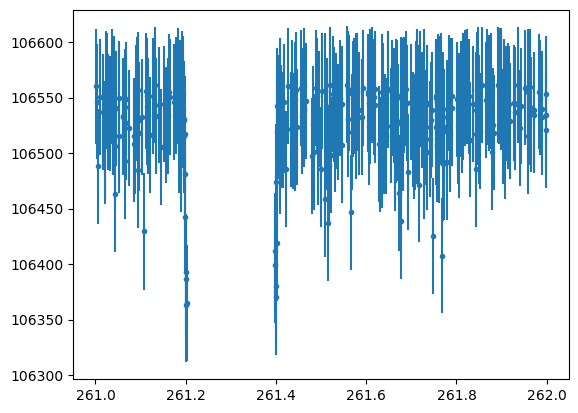

In [14]:
plt.errorbar(time_filtered, flux_filtered, yerr=flux_err_filtered, label='Observed Data', fmt='.')

In [15]:
# Simpsons integral approximation
"""
This function takes the following imputs:
f: the integrand
x0: lower limit of integral
xn: upper limit of integral
n: number of different subintervals

delta_x: the width of each subinterval

This function uses parabolas to create an approximation of an integral
"""
def approximate_int_simpsons(f, x0, xn, n):
    delta_x = (xn - x0) / n
    simpsons_approx = 0
    
    for i in range(n):
        xi = x0 + i * delta_x
        xi1 = x0 + (i + 1) * delta_x
        simpsons_approx += (f(xi) +  4*f((xi + xi1) / 2) + f(xi1)) * delta_x / 6
        
    return simpsons_approx


In [16]:
def lambda_function(p, z):
    if 1 + p < z:
        y = 0
    elif math.fabs(1-p) < z and z <= 1 + p:
        k0 = math.acos((p**2+z**2-1)/(2*p*z))
        k1 = math.acos((1-p**2+z**2)/(2*z))
        y = (p**2 * k0 + k1 - math.sqrt((4*z**2 - (1+z**2-p**2)**2)/4))/math.pi
    elif z <= 1-p:
        y = p**2
    elif z <= p-1:
        y = 1

    return y

def flux_function(p, z):
    return 1 - lambda_function(p, math.fabs(z))

In [2]:
# Function calculate F_theoretical
def calculate_F_theoretical(p, t0, tau, time_filtered, average_flux_filtered):
    z = (time_filtered - t0) / tau
    u = lambda r: (1 - r**2)**0.5
    calc_i = lambda r: u(r)**0.5
    
    def integrand_numerator(r):
        return np.array([calc_i(r) * flux_function(p, z_val) * 2 * r for z_val in z])
    
    def integrand_denominator(r):
        return np.array([calc_i(r) * 2 * r for _ in z])
    
    numerator = np.array([approximate_int_simpsons(lambda r: integrand_numerator(r)[i], 0, 1, 100) for i in range(len(z))])
    denominator = np.array([approximate_int_simpsons(lambda r: integrand_denominator(r)[i], 0, 1, 100) for i in range(len(z))])

    F_theoretical = numerator / denominator
    F_theoretical *= average_flux_filtered

    return F_theoretical
    

In [17]:
p = 0.0775
t0 = 261.3
tau = 0.1
z = (time_filtered-t0)/tau
u = lambda r: (1 - r**2)**0.5
calc_i = lambda r: u(r)**0.5

    
# Function has an integral in both the numerator and denominator, so they will be computed indidual
def integrand_numerator(r):
    result = np.array([calc_i(r) * flux_function(p, z_val) * 2 * r for z_val in z])
    return result

numerator =([approximate_int_simpsons(lambda r: integrand_numerator(r)[i], 0, 1, 100) for i in range(len(z))])

def integrand_denominator(r):
    result1 = np.array([calc_i(r) * 2 * r for z_val in z])
    return result1

denominator = ([approximate_int_simpsons(lambda r: integrand_denominator(r)[i], 0, 1, 100) for i in range(len(z))])

unobscured_flux = average_flux_filtered

numerator = np.array(numerator)
denominator = np.array(denominator)
F_theoretical = numerator / denominator

F_theoretical *= unobscured_flux

print (F_theoretical)



[106527.5546875  106527.5546875  106527.5546875  106527.5546875
 106527.5546875  106527.5546875  106527.5546875  106527.5546875
 106527.5546875  106527.5546875  106527.5546875  106527.5546875
 106527.5546875  106527.5546875  106527.5546875  106527.5546875
 106527.5546875  106527.5546875  106527.5546875  106527.5546875
 106527.5546875  106527.5546875  106527.5546875  106527.5546875
 106527.5546875  106527.5546875  106527.5546875  106527.5546875
 106527.5546875  106527.5546875  106527.5546875  106527.5546875
 106527.5546875  106527.5546875  106527.5546875  106527.5546875
 106527.5546875  106527.5546875  106527.5546875  106527.5546875
 106527.5546875  106527.5546875  106527.5546875  106527.5546875
 106527.5546875  106527.5546875  106527.5546875  106527.5546875
 106527.5546875  106527.5546875  106527.5546875  106527.5546875
 106527.5546875  106527.5546875  106527.5546875  106527.5546875
 106527.5546875  106527.5546875  106527.5546875  106527.5546875
 106501.22673968 106454.51820343 106426.

In [18]:
# Compute chi squared
chi_squared = np.sum(((flux_filtered - F_theoretical)/flux_err_filtered)**2)
print (chi_squared)

358.3995806642939


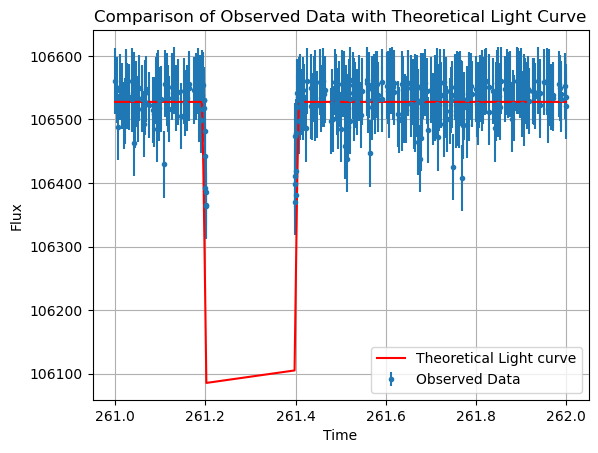

In [19]:
# Problem 2

#Plotting observed vs theoretical data
plt.figure
plt.errorbar(time_filtered, flux_filtered, yerr=flux_err_filtered, label='Observed Data', fmt='.')
plt.plot(time_filtered, F_theoretical, label='Theoretical Light curve', color='red')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Comparison of Observed Data with Theoretical Light Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
"""
I would say that this is a very good fit. Although there is a gap in the observed data, in which the theretical is predicted. 
But the area outside the gapmatches very well.
"""

In [20]:
# Compute liklihood of chi-squared value 
N = len(time_filtered)
M = 3
nu = N - M

p_value = 1 - gammainc(nu / 2, chi_squared / 2)
print (p_value)

0.01903824310119029


In [ ]:
"""
This is a very low p value and indicates that the fit is not good.
"""

In [21]:
# Function calculate F_theoretical
def calculate_F_theoretical(p, t0, tau, time_filtered, average_flux_filtered):
    z = (time_filtered - t0) / tau
    u = lambda r: (1 - r**2)**0.5
    calc_i = lambda r: u(r)**0.5
    
    def integrand_numerator(r):
        return np.array([calc_i(r) * flux_function(p, z_val) * 2 * r for z_val in z])
    
    def integrand_denominator(r):
        return np.array([calc_i(r) * 2 * r for _ in z])
    
    numerator = np.array([approximate_int_simpsons(lambda r: integrand_numerator(r)[i], 0, 1, 100) for i in range(len(z))])
    denominator = np.array([approximate_int_simpsons(lambda r: integrand_denominator(r)[i], 0, 1, 100) for i in range(len(z))])

    F_theoretical = numerator / denominator
    F_theoretical *= average_flux_filtered

    return F_theoretical
    

In [23]:
# Problem 3
tau_values = np.arange(0.08, 0.13, 0.01)

best_tau = None
min_chi_squared = np.inf

tau_values = np.arange(0.08, 0.13, 0.01)

for tau in tau_values:
    F_theoretical = calculate_F_theoretical(p, t0, tau, time_filtered, average_flux_filtered)
    
    chi_squared = np.sum(((flux_filtered - F_theoretical) / flux_err_filtered) ** 2)
    
    # Check if it is the lowest chi-squared 
    if chi_squared < min_chi_squared:
        min_chi_squared = chi_squared
        best_tau = tau

print("Best fitting tau:", best_tau)
print("Minimum chi-squared:", min_chi_squared)


Best fitting tau: 0.08
Minimum chi-squared: 146.15162206207634


In [24]:
# Plot 
F_theoretical_best_fit = calculate_F_theoretical(p, t0, 0.08, time_filtered, average_flux_filtered)

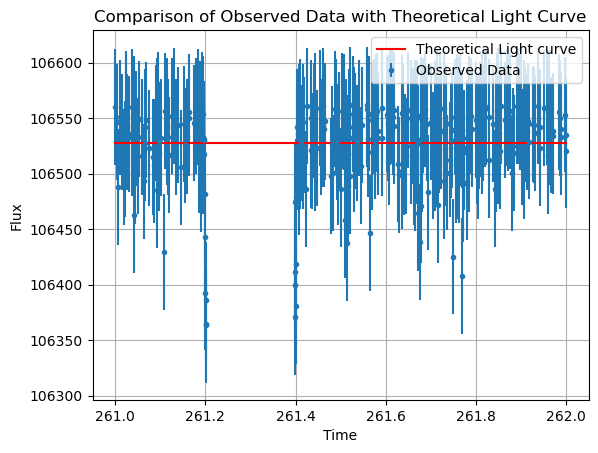

In [26]:
plt.figure
plt.errorbar(time_filtered, flux_filtered, yerr=flux_err_filtered, label='Observed Data', fmt='.')
plt.plot(time_filtered, F_theoretical_best_fit, label='Theoretical Light curve', color='red')
plt.xlabel('Time')
plt.ylabel('Flux')
plt.title('Comparison of Observed Data with Theoretical Light Curve')
plt.legend()
plt.grid(True)
plt.show()